--- Задача 3.1: Фурье LPF vs Стандартные фильтры ---
Метрики качества (MSE, SSIM):
  Median: MSE=192.92, SSIM=0.629
  Gaussian: MSE=162.90, SSIM=0.609
  Bilateral: MSE=116.99, SSIM=0.665
  Fourier LPF: MSE=206.54, SSIM=0.608


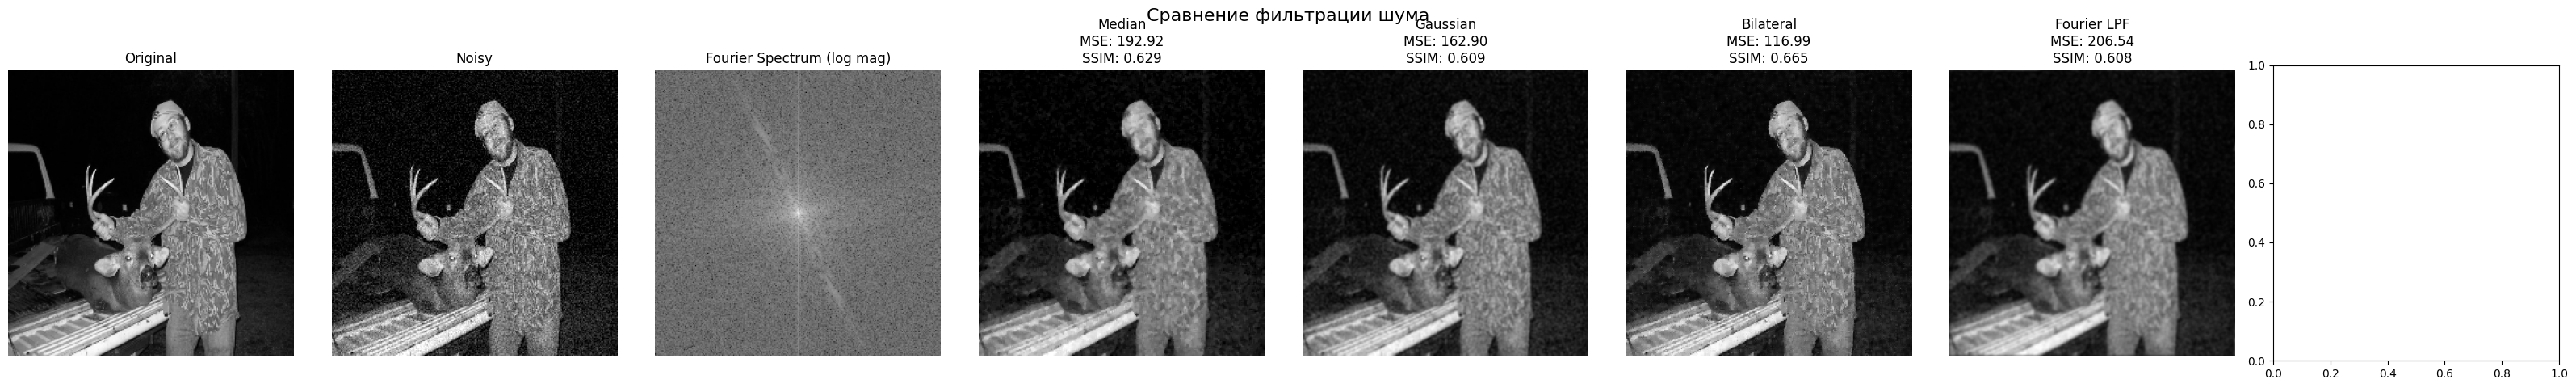


--- Задача 3.2: Фильтрация периодического шума Фурье ---

Обработка изображения 1/10


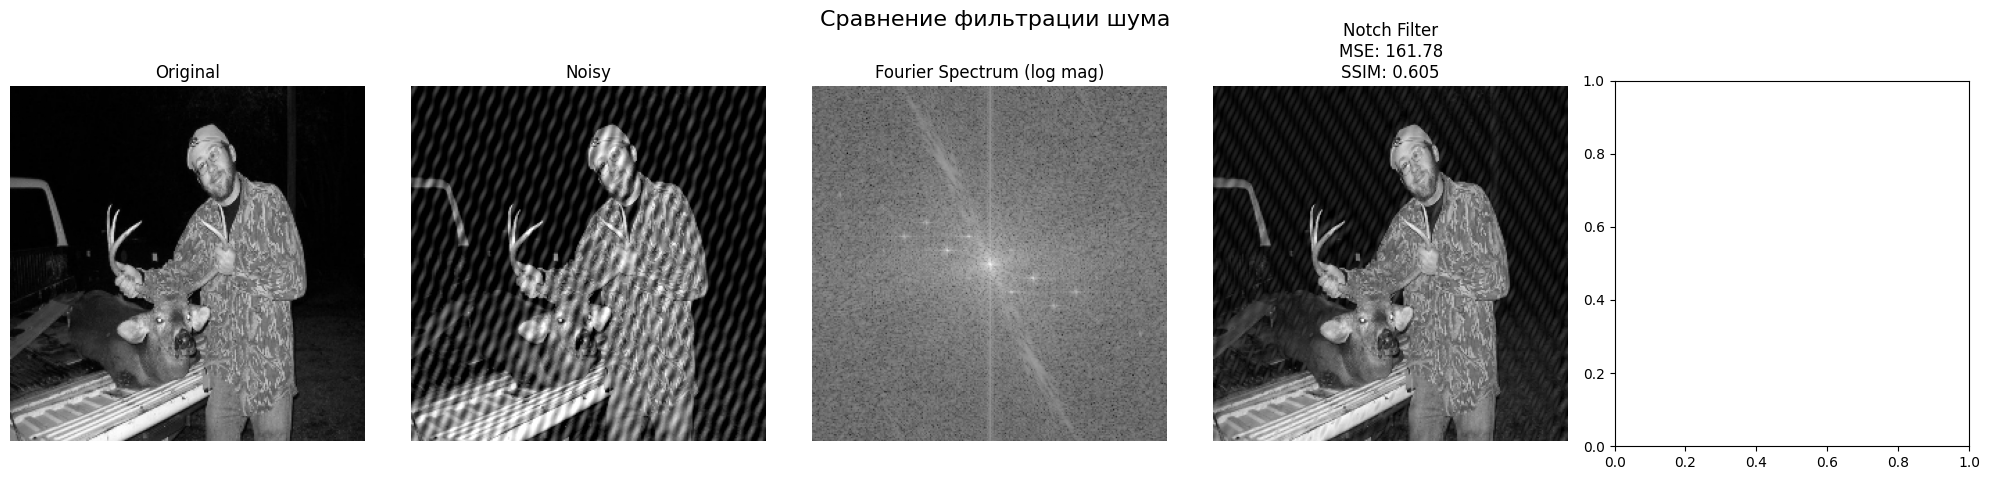

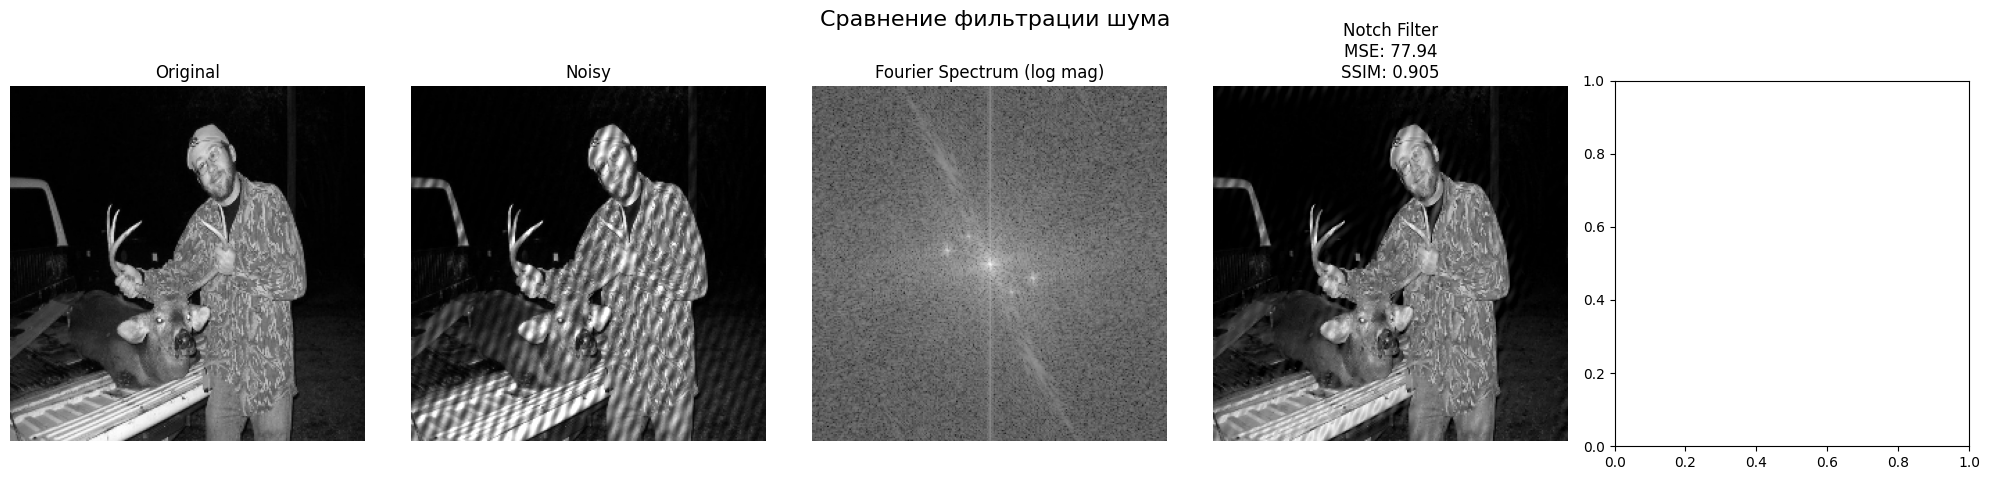

  Аддитивный шум -> Фильтр Notch: MSE=161.78, SSIM=0.605
  Мультиплик. шум -> Фильтр Notch: MSE=77.94, SSIM=0.905

Обработка изображения 2/10
  Аддитивный шум -> Фильтр Notch: MSE=155.93, SSIM=0.607
  Мультиплик. шум -> Фильтр Notch: MSE=81.62, SSIM=0.901

Обработка изображения 3/10
  Аддитивный шум -> Фильтр Notch: MSE=142.00, SSIM=0.620
  Мультиплик. шум -> Фильтр Notch: MSE=82.13, SSIM=0.905

Обработка изображения 4/10
  Аддитивный шум -> Фильтр Notch: MSE=135.60, SSIM=0.627
  Мультиплик. шум -> Фильтр Notch: MSE=80.33, SSIM=0.904

Обработка изображения 5/10
  Аддитивный шум -> Фильтр Notch: MSE=147.35, SSIM=0.619
  Мультиплик. шум -> Фильтр Notch: MSE=78.99, SSIM=0.904

Обработка изображения 6/10
  Аддитивный шум -> Фильтр Notch: MSE=169.13, SSIM=0.604
  Мультиплик. шум -> Фильтр Notch: MSE=82.38, SSIM=0.901

Обработка изображения 7/10
  Аддитивный шум -> Фильтр Notch: MSE=159.48, SSIM=0.605
  Мультиплик. шум -> Фильтр Notch: MSE=79.69, SSIM=0.902

Обработка изображения 8/10
  Адди

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error as mse
import random
import math
import time

def load_image_grayscale(path):
    img = cv2.imread(path)
    if img is None:
        print(f"Ошибка: не удалось загрузить изображение {path}")
        return None
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def generate_base_image(size=(512, 512)):
    try:
        img_path = '/content/181a0ee39a0c9a78.jpg'
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        return cv2.resize(img_gray, size)
    except FileNotFoundError:
        print("Предупреждение: Тестовое изображение не найдено, используется случайный шум.")
        return (np.random.rand(size[0], size[1]) * 255).astype(np.uint8)
    except Exception as e:
         print(f"Ошибка при загрузке базового изображения: {e}, используется случайный шум.")
         return (np.random.rand(size[0], size[1]) * 255).astype(np.uint8)


def add_gaussian_noise(image, mean=0, sigma=25):
    row, col = image.shape
    gauss = np.random.normal(mean, sigma, (row, col))
    noisy = image + gauss
    noisy = np.clip(noisy, 0, 255)
    return noisy.astype(np.uint8)

def add_periodic_noise(image, amplitude=30, freq_u=30, freq_v=0):
    rows, cols = image.shape
    x = np.arange(cols)
    y = np.arange(rows)
    xx, yy = np.meshgrid(x, y)

    # Синусоидальный шум
    # 2 * pi * (u*x/M + v*y/N)
    noise_pattern = amplitude * np.sin(2 * np.pi * (freq_u * xx / cols + freq_v * yy / rows))
    # Добавляем еще компоненту для сложности
    noise_pattern += amplitude/2 * np.cos(2 * np.pi * (freq_u/2 * xx / cols + freq_v*2 * yy / rows + np.pi/4))


    # Аддитивный шум
    noisy_additive = image + noise_pattern
    noisy_additive = np.clip(noisy_additive, 0, 255)
    noisy_additive = noisy_additive.astype(np.uint8)

    # Мультипликативная деградация (как в описании?)
    noise_norm = (noise_pattern - noise_pattern.min()) / (noise_pattern.max() - noise_pattern.min()) # к [0,1]
    noise_multiplier = 1 + (noise_norm - 0.5)

    noisy_multiplicative = image.astype(np.float32) * noise_multiplier
    noisy_multiplicative = np.clip(noisy_multiplicative, 0, 255)
    noisy_multiplicative = noisy_multiplicative.astype(np.uint8)

    return noisy_additive, noisy_multiplicative, noise_pattern


def apply_median_filter(image, ksize=5):
    return cv2.medianBlur(image, ksize)

def apply_gaussian_filter(image, ksize=(5, 5), sigmaX=0):
    return cv2.GaussianBlur(image, ksize, sigmaX)

def apply_bilateral_filter(image, d=9, sigmaColor=75, sigmaSpace=75):
    return cv2.bilateralFilter(image, d, sigmaColor, sigmaSpace)

def apply_nl_means_filter(image, h=10, templateWindowSize=7, searchWindowSize=21):
    return cv2.fastNlMeansDenoising(image, None, h, templateWindowSize, searchWindowSize)


# Фурье-фильтры

def fourier_transform(image):
    img_float32 = np.float32(image)
    dft = cv2.dft(img_float32, flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)
    return dft_shifted

def inverse_fourier_transform(dft_shifted):
    f_ishift = np.fft.ifftshift(dft_shifted)
    img_back = cv2.idft(f_ishift, flags=cv2.DFT_SCALE | cv2.DFT_REAL_OUTPUT)
    img_back = np.clip(img_back, 0, 255)
    img_back = img_back.astype(np.uint8)
    return img_back

def get_magnitude_spectrum(dft_shifted):
    # magnitude = |Re + i*Im| = sqrt(Re^2 + Im^2)
    magnitude = cv2.magnitude(dft_shifted[:, :, 0], dft_shifted[:, :, 1])
    magnitude_spectrum = np.log1p(magnitude)
    cv2.normalize(magnitude_spectrum, magnitude_spectrum, 0, 1, cv2.NORM_MINMAX)
    return magnitude_spectrum


def apply_fourier_low_pass(image, D0=30):
    dft_shifted = fourier_transform(image)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    mask = np.zeros((rows, cols, 2), np.float32)
    for r in range(rows):
        for c in range(cols):
            D = np.sqrt((r - crow)**2 + (c - ccol)**2)
            mask[r, c] = np.exp(-(D**2) / (2 * (D0**2)))

    fshift_filtered = dft_shifted * mask

    img_filtered = inverse_fourier_transform(fshift_filtered)
    return img_filtered

def apply_fourier_notch_filter(image, notch_points, radius=10, notch_type='gaussian'):
    dft_shifted = fourier_transform(image)
    rows, cols = image.shape
    crow, ccol = rows // 2, cols // 2

    mask = np.ones((rows, cols, 2), np.float32)

    all_points = set()
    for r_peak, c_peak in notch_points:
        all_points.add((r_peak, c_peak))
        sym_r = 2 * crow - r_peak
        sym_c = 2 * ccol - c_peak
        if 0 <= sym_r < rows and 0 <= sym_c < cols:
             all_points.add((sym_r, sym_c))

    for r_peak, c_peak in all_points:
      if r_peak == crow and c_peak == ccol:
          continue
      for r in range(rows):
          for c in range(cols):
              D = np.sqrt((r - r_peak)**2 + (c - c_peak)**2)
              if notch_type == 'ideal':
                  if D <= radius:
                      mask[r, c] = 0.0
              elif notch_type == 'gaussian':
                  mask[r, c] = mask[r, c] * (1 - np.exp(-(D**2) / (2 * (radius**2))))
              else:
                   if D <= radius:
                      mask[r, c] = 0.0

    fshift_filtered = dft_shifted * mask
    img_filtered = inverse_fourier_transform(fshift_filtered)
    return img_filtered


def calculate_metrics(original, processed):
    m = mse(original, processed)
    s = ssim(original, processed, data_range=original.max() - original.min())
    return m, s

def visualize_comparison(original, noisy, filtered_dict, metrics_dict, fourier_spectrum=None):
    num_images = 3 + len(filtered_dict)
    if fourier_spectrum is not None:
      num_images += 1

    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 4, 5))
    fig.suptitle("Сравнение фильтрации шума", fontsize=16)

    ax = axes[0]
    ax.imshow(original, cmap='gray')
    ax.set_title("Original")
    ax.axis('off')

    ax = axes[1]
    ax.imshow(noisy, cmap='gray')
    ax.set_title("Noisy")
    ax.axis('off')

    if fourier_spectrum is not None:
        ax = axes[2]
        ax.imshow(fourier_spectrum, cmap='gray')
        ax.set_title("Fourier Spectrum (log mag)")
        ax.axis('off')
        start_index = 3
    else:
      start_index = 2

    i = start_index
    for name, img in filtered_dict.items():
        ax = axes[i]
        ax.imshow(img, cmap='gray')
        mse_val, ssim_val = metrics_dict[name]
        ax.set_title(f"{name}\nMSE: {mse_val:.2f}\nSSIM: {ssim_val:.3f}")
        ax.axis('off')
        i += 1

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


print("--- Задача 3.1: Фурье LPF vs Стандартные фильтры ---")

original_img = generate_base_image(size=(256, 256))
if original_img is None:
    print("Не удалось создать/загрузить изображение. Выход.")
    exit()

noisy_img_gauss = add_gaussian_noise(original_img, sigma=20)

filtered_median = apply_median_filter(noisy_img_gauss, ksize=3)
filtered_gaussian = apply_gaussian_filter(noisy_img_gauss, ksize=(3, 3))
filtered_bilateral = apply_bilateral_filter(noisy_img_gauss, d=5, sigmaColor=30, sigmaSpace=30)

filtered_fourier_lpf = apply_fourier_low_pass(noisy_img_gauss, D0=40)

metrics = {}
metrics['Median'] = calculate_metrics(original_img, filtered_median)
metrics['Gaussian'] = calculate_metrics(original_img, filtered_gaussian)
metrics['Bilateral'] = calculate_metrics(original_img, filtered_bilateral)
metrics['Fourier LPF'] = calculate_metrics(original_img, filtered_fourier_lpf)

print("Метрики качества (MSE, SSIM):")
for name, (m, s) in metrics.items():
    print(f"  {name}: MSE={m:.2f}, SSIM={s:.3f}")

filtered_images_task31 = {
    'Median': filtered_median,
    'Gaussian': filtered_gaussian,
    'Bilateral': filtered_bilateral,
    'Fourier LPF': filtered_fourier_lpf
}

dft_shifted_gauss = fourier_transform(noisy_img_gauss)
spectrum_gauss = get_magnitude_spectrum(dft_shifted_gauss)

visualize_comparison(original_img, noisy_img_gauss, filtered_images_task31, metrics, fourier_spectrum=spectrum_gauss)

print("\n--- Задача 3.2: Фильтрация периодического шума Фурье ---")

# Параметры для генерации и фильтрации
num_images_for_avg = 10
total_mse_add = 0
total_ssim_add = 0
total_mse_mul = 0
total_ssim_mul = 0

# Параметры периодического шума
noise_amplitude = 40
noise_freq_u = 30
noise_freq_v = 10

img_shape = original_img.shape # H, W
rows, cols = img_shape
crow, ccol = rows // 2, cols // 2

# Для sin(2*pi*(freq_u*x/cols + freq_v*y/rows))
peak1_r, peak1_c = crow + noise_freq_v, ccol + noise_freq_u
peak2_r, peak2_c = crow - noise_freq_v, ccol - noise_freq_u

# Для cos(2*pi*(freq_u/2 * x/cols + freq_v*2 * y/rows))
noise_freq_u2 = noise_freq_u / 2
noise_freq_v2 = noise_freq_v * 2
peak3_r, peak3_c = int(crow + noise_freq_v2), int(ccol + noise_freq_u2)
peak4_r, peak4_c = int(crow - noise_freq_v2), int(ccol - noise_freq_u2)

notch_filter_points = []
for r, c in [(peak1_r, peak1_c), (peak2_r, peak2_c), (peak3_r, peak3_c), (peak4_r, peak4_c)]:
  r_int, c_int = int(round(r)), int(round(c))
  if 0 <= r_int < rows and 0 <= c_int < cols:
      if r_int != crow or c_int != ccol:
          notch_filter_points.append((r_int, c_int))

notch_filter_points = list(set(notch_filter_points))

# Цикл для усреднения
for i in range(num_images_for_avg):
    print(f"\nОбработка изображения {i+1}/{num_images_for_avg}")
    original_i = original_img.copy()
    if original_i is None: continue

    amp_i = noise_amplitude + random.uniform(-5, 5)
    fu_i = noise_freq_u + random.uniform(-2, 2)
    fv_i = noise_freq_v + random.uniform(-1, 1)

    noisy_add_i, noisy_mul_i, _ = add_periodic_noise(original_i, amplitude=amp_i, freq_u=fu_i, freq_v=fv_i)

    filter_radius = 5
    filtered_notch_add = apply_fourier_notch_filter(noisy_add_i, notch_filter_points, radius=filter_radius, notch_type='gaussian')
    filtered_notch_mul = apply_fourier_notch_filter(noisy_mul_i, notch_filter_points, radius=filter_radius, notch_type='gaussian')

    mse_add_i, ssim_add_i = calculate_metrics(original_i, filtered_notch_add)
    mse_mul_i, ssim_mul_i = calculate_metrics(original_i, filtered_notch_mul)

    total_mse_add += mse_add_i
    total_ssim_add += ssim_add_i
    total_mse_mul += mse_mul_i
    total_ssim_mul += ssim_mul_i

    if i == 0:
        # Спектр аддитивно-зашумленного изображения
        dft_shifted_add = fourier_transform(noisy_add_i)
        spectrum_add = get_magnitude_spectrum(dft_shifted_add)
        visualize_comparison(original_i, noisy_add_i, {'Notch Filter': filtered_notch_add},
                             {'Notch Filter': (mse_add_i, ssim_add_i)}, fourier_spectrum=spectrum_add)

        # Спектр мультипликативно-зашумленного изображения
        dft_shifted_mul = fourier_transform(noisy_mul_i)
        spectrum_mul = get_magnitude_spectrum(dft_shifted_mul)
        visualize_comparison(original_i, noisy_mul_i, {'Notch Filter': filtered_notch_mul},
                             {'Notch Filter': (mse_mul_i, ssim_mul_i)}, fourier_spectrum=spectrum_mul)

    print(f"  Аддитивный шум -> Фильтр Notch: MSE={mse_add_i:.2f}, SSIM={ssim_add_i:.3f}")
    print(f"  Мультиплик. шум -> Фильтр Notch: MSE={mse_mul_i:.2f}, SSIM={ssim_mul_i:.3f}")


# 6. Расчет средних метрик
avg_mse_add = total_mse_add / num_images_for_avg
avg_ssim_add = total_ssim_add / num_images_for_avg
avg_mse_mul = total_mse_mul / num_images_for_avg
avg_ssim_mul = total_ssim_mul / num_images_for_avg

print("\n--- Результаты Task 3.2 (усредненные по {} изображениям) ---".format(num_images_for_avg))
print(f"Фильтрация аддитивного периодического шума:")
print(f"  Средний MSE: {avg_mse_add:.2f}")
print(f"  Средний SSIM: {avg_ssim_add:.3f}")
print(f"\nФильтрация мультипликативного периодического шума (прямым Notch):")
print(f"  Средний MSE: {avg_mse_mul:.2f}")
print(f"  Средний SSIM: {avg_ssim_mul:.3f}")